In [581]:
# LSTM + multistep prediction (single)

In [1]:
conda install tensorflow

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array
import pandas as pd 
from keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow as tf
import os



/var/folders/6g/0jt3knmj2hj4lmvq8xkclwc80000gn/T/ipykernel_50217/2320318245.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [3]:

# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [4]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

In [26]:
# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series.values
	# transform data to be stationary
	diff_series = difference(raw_values, 1)
	diff_values = diff_series.values
	diff_values = diff_values.reshape(len(diff_values), 1)
	# rescale values to -1, 1
	scaler = MinMaxScaler(feature_range=(0, 1))
	scaled_values = scaler.fit_transform(diff_values)
	scaled_values = scaled_values.reshape(len(scaled_values), 1)
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(scaled_values, n_lag, n_seq)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return scaler, train, test

In [6]:
# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
	# reshape training into [samples, timesteps, features]
	X, y = train[:, 0:n_lag], train[:, n_lag:]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	# design network

	early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
													patience=2,
													mode='min')
	model_path = 'model'
	filename = os.path.join(model_path, 'tmp_checkpoint_v8.h5')
	checkpoint = ModelCheckpoint(filename, monitor='loss', verbose=1, save_best_only=True, mode='auto')
	model = Sequential()
	model.add(LSTM(n_neurons, batch_input_shape=(1, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(y.shape[1]))
	model.compile(loss='mean_squared_error', optimizer='adam')
	# fit network
	model.fit(X, y, epochs=nb_epoch,  shuffle=False,callbacks=[early_stopping, checkpoint])
	return model
 

In [7]:

# make one forecast with an LSTM,
def forecast_model(model, X, n_batch):
	# reshape input pattern to [samples, timesteps, features]
	X = X.reshape(1, 1, len(X))
	# make forecast
	forecast = model.predict(X)
	# convert to array
	return [x for x in forecast[0, :]]

In [8]:
# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = forecast_model(model, X, n_batch)
		# store the forecast
		forecasts.append(forecast)
	return forecasts

In [9]:
# invert differenced forecast
def inverse_difference(last_ob, forecast):
	# invert first forecast
	inverted = list()
	inverted.append(forecast[0] + last_ob)
	# propagate difference forecast using inverted first value
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + inverted[i-1])
	return inverted


In [10]:

# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
	inverted = list()
	for i in range(len(forecasts)):
		# create array from forecast
		forecast = array(forecasts[i])
		forecast = forecast.reshape(1, len(forecast))
		# invert scaling
		inv_scale = scaler.inverse_transform(forecast)
		inv_scale = inv_scale[0, :]
		# invert differencing
		index = len(series) - n_test + i - 1
		last_ob = series.values[index]
		inv_diff = inverse_difference(last_ob, inv_scale)
		# store
		inverted.append(inv_diff)
	return inverted

In [11]:

# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))
 

In [12]:
# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	pyplot.plot(series.values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series.values[off_s]] + forecasts[i]
		pyplot.plot(xaxis, yaxis, color='red')
	# show the plot
	pyplot.show()

In [33]:
# load dataset
series = read_csv('../data/cpu_memory_usage_v1.csv', header=0, infer_datetime_format=True)
series['time'] = pd.to_datetime(series['time'], unit='ns')
series = series.loc[series.pod_name == 'drive-az2-prd-69cbb999bc-st442']
date_time = pd.to_datetime(series['time'], format='%Y-%M-%D %H:%M:%S')
series = series.loc[:,['memory_working_set_bytes']]
series
# configure
n_lag = 1
n_seq = 1
n_test = 3860
n_epochs = 100
n_batch = 128
n_neurons = 1


In [34]:
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)

In [35]:
# fit model
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)

Epoch 1/100
424/483 [=========================>....] - ETA: 0s - loss: 0.1223
Epoch 1: loss improved from inf to 0.10767, saving model to model/tmp_checkpoint_v8.h5
483/483 [==============================] - 1s 613us/step - loss: 0.1077
Epoch 2/100
468/483 [============================>.] - ETA: 0s - loss: 7.2664e-05
Epoch 2: loss improved from 0.10767 to 0.00007, saving model to model/tmp_checkpoint_v8.h5
483/483 [==============================] - 0s 564us/step - loss: 7.1771e-05
Epoch 3/100
441/483 [==========================>...] - ETA: 0s - loss: 6.2611e-05
Epoch 3: loss improved from 0.00007 to 0.00006, saving model to model/tmp_checkpoint_v8.h5
483/483 [==============================] - 0s 584us/step - loss: 6.0992e-05
Epoch 4/100
455/483 [===========================>..] - ETA: 0s - loss: 6.1933e-05
Epoch 4: loss did not improve from 0.00006
483/483 [==============================] - 0s 687us/step - loss: 6.0994e-05
Epoch 5/100
461/483 [===========================>..] - ETA: 0s -

In [36]:
# make forecasts
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
# forecasts = model.predict(test)

1/1 [==============================] - 0s 12ms/step


In [1355]:
# inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test)

In [37]:
actual = [row[n_lag:] for row in test]
# actual = inverse_transform(series, actual, scaler, n_test)

In [38]:
# evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)

t+1 RMSE: 0.005973


In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (1, 1)                    12        
                                                                 
 dense_1 (Dense)             (1, 4)                    8         
                                                                 
Total params: 20
Trainable params: 20
Non-trainable params: 0
_________________________________________________________________


/opt/homebrew/anaconda3/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


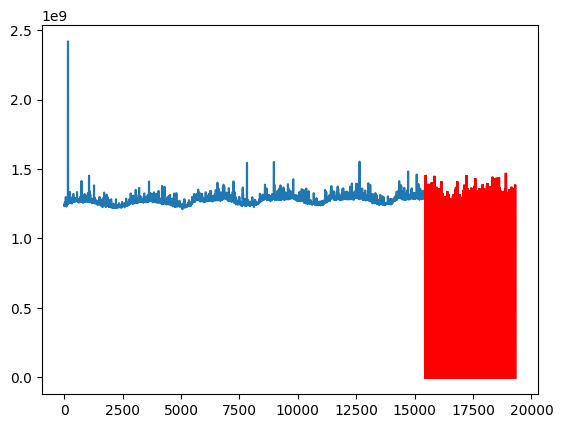

In [39]:
# plot forecasts
plot_forecasts(series, forecasts, n_test)